In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2

from PIL import Image

import matplotlib.pyplot as plt

from torchinfo import summary

import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


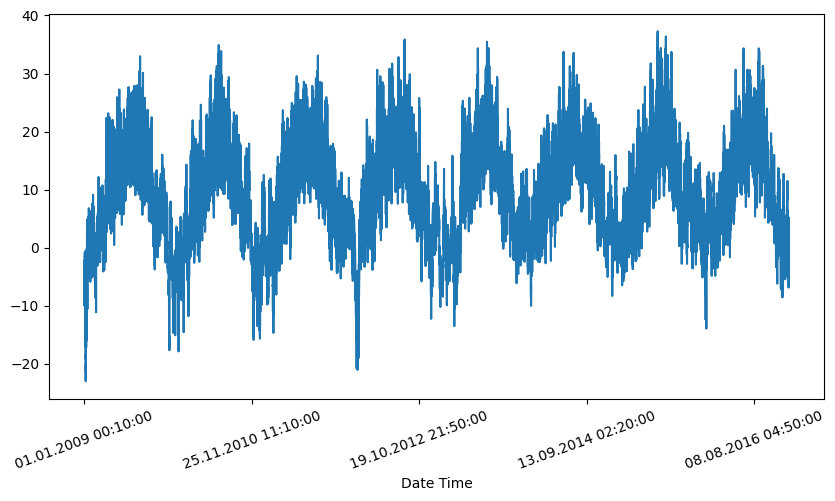

In [3]:
temp = df['T (degC)']
temp.index = df['Date Time']

plt.figure(figsize=(10,5))
temp.plot()

plt.xticks(rotation=20)
plt.show()

In [4]:
temp = df[['T (degC)']].to_numpy().astype(np.float32)
temp = temp[:50000]

In [5]:
len(temp)

50000

In [6]:
num_data = len(temp)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temp[:train_size]
val_data = temp[train_size:train_size + val_size]
test_data = temp[train_size + val_size:]

print(len(train_data), len(val_data), len(test_data))


40000 5000 5000


In [7]:
scaler = StandardScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

print(f'mean: {train_data_scaled.mean():.4f}, std: {train_data_scaled.std():.4f}')

mean: 0.0000, std: 1.0000


In [8]:
class JenaTempDataset(Dataset):
	def __init__(self, temp, seq_length):
		self.temp = temp
		self.seq_length = seq_length

	def __len__(self):
		return len(self.temp) - self.seq_length

	def __getitem__(self, idx):
		inputs = self.temp[idx : idx + self.seq_length]
		targets = self.temp[idx + self.seq_length]
		return torch.tensor(inputs), torch.tensor(targets)

In [9]:
seq_length = 10
train_dataset = JenaTempDataset(train_data_scaled, seq_length)
val_dataset = JenaTempDataset(val_data_scaled, seq_length)
test_dataset = JenaTempDataset(test_data_scaled, seq_length)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [10]:
class LSTMModel(nn.Module):
	def __init__(self):
		super().__init__()
		self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=2, batch_first=True)
		self.linear = nn.Linear(32, 1)

	def forward(self, x):
		lstm_out, _ = self.lstm(x)
		out = self.linear(lstm_out)
		return out
	
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
model = LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [14]:
# @title Train loop

epochs = 5
step = 0
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        preds = model(inputs)
        preds = preds[:, -1, :]  # Take only the last time step
        loss = loss_fn(preds, targets)

        loss.backward()
        opt.step()
        opt.zero_grad()

        step += 1
        if step % 100 == 0:
            print(f'step {step}, train loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_loader:
            inputs = val_batch[0].to(device)
            targets = val_batch[1].to(device)
            preds = model(inputs)
            preds = preds[:, -1, :]  # Take only the last time step
            loss = loss_fn(preds, targets)
            losses.append(loss.item())

    val_loss_avg = sum(losses) / len(losses)
    print(f'\nepoch {epoch+1}/{epochs}, val loss: {val_loss_avg:.4f}\n')

step 100, train loss: 0.0049
step 200, train loss: 0.0048
step 300, train loss: 0.0021

epoch 1/5, val loss: 0.0019

step 400, train loss: 0.0016
step 500, train loss: 0.0026
step 600, train loss: 0.0022

epoch 2/5, val loss: 0.0014

step 700, train loss: 0.0036
step 800, train loss: 0.0018
step 900, train loss: 0.0021

epoch 3/5, val loss: 0.0011

step 1000, train loss: 0.0015
step 1100, train loss: 0.0016
step 1200, train loss: 0.0021

epoch 4/5, val loss: 0.0009

step 1300, train loss: 0.0013
step 1400, train loss: 0.0015
step 1500, train loss: 0.0015

epoch 5/5, val loss: 0.0008



In [15]:
# @title Test

test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_loader:
        inputs = test_batch[0].to(device)
        preds = model(inputs)  # [batch size, sequence length, 1]
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)

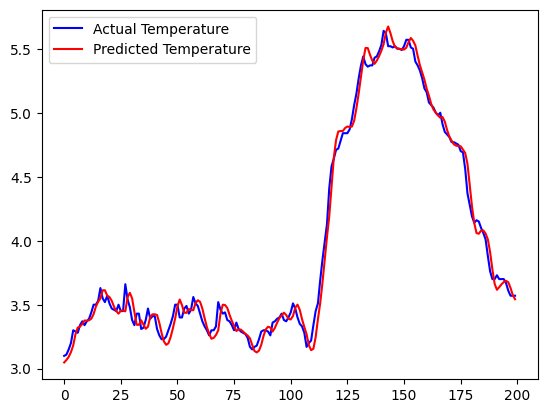

In [16]:
# @title 시각화
test_targets = test_data[seq_length:]

plt.plot(test_targets[:200], color='blue', label='Actual Temperature')
plt.plot(test_preds[:200], color='red', label='Predicted Temperature')
plt.legend()
plt.show()